In [1]:
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import s3fs
import seaborn as sns
from scipy import stats

sys.path.append("/Users/fgu/dev/projects/entropy")
import entropy.data.aggregators as ag
import entropy.data.cleaners as cl
import entropy.data.make_data as md
import entropy.data.selectors as sl
import entropy.data.validators as vl
import entropy.helpers.aws as ha
import entropy.helpers.data as hd
import entropy.helpers.helpers as hh

pd.set_option("display.max_rows", 120)
pd.set_option("display.max_columns", 120)
pd.set_option("max_colwidth", None)
%load_ext autoreload
%autoreload 2

fs = s3fs.S3FileSystem(profile="3di")

month = pd.Grouper(key="date", freq="m")
idx_cols = ["user_id", month]

In [6]:
df = hd.read_txn_data("777")

Time for read_txn_data                 : 9.10 seconds


## User-month-level count-based entropy

For each category `merchant`, `tag`, and `auto_tag`, we calculate both category-based and category-time-based entropy. Could also add a count/amount dimension to the permutation. But don't do this for now, as I'd think that they correlate strongly.

In [ ]:
dfe = ag.count_based_entropy_scores(df)
dfe.head(3)

### Distribution of (cat) and (cat, wknd) scores

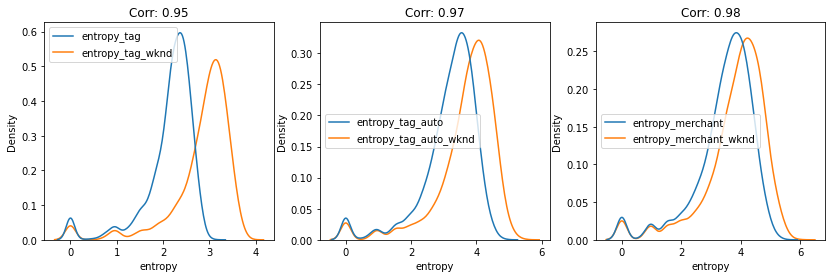

In [14]:
fig, ax = plt.subplots(1, 3, figsize=(14, 4))
for fig_idx, col_idx in enumerate(list(range(0, len(dfe.columns), 4))):
    d = dfe.iloc[:, col_idx : col_idx + 2]
    sns.kdeplot(data=d, ax=ax[fig_idx])
    ax[fig_idx].set(xlabel="entropy", title=("Corr: {:.2}".format(d.corr().iloc[0, 1])))

(cat, wknd) scores have higher variance, since there are more total categories and hence a higher entropy score upper bound. Overall, thought, the distributions look very similar, and correlations are high.

### Correlatioin among measurs

Correlation among measures is faily high.

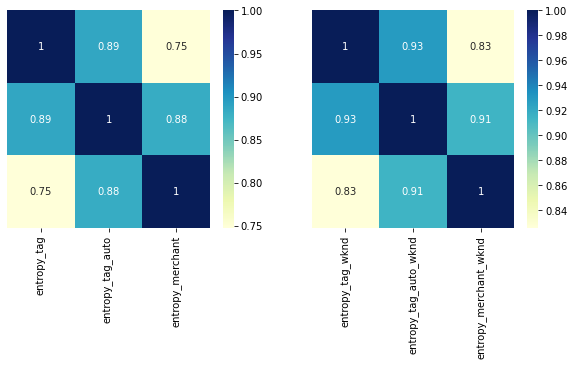

In [8]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
m = dfe[dfe.columns[~dfe.columns.str.contains("smooth|wknd")]].corr()
sns.heatmap(m, cmap="YlGnBu", annot=True, ax=ax[0], yticklabels=False)
m = dfe[
    dfe.columns[dfe.columns.str.contains("wknd") & ~dfe.columns.str.contains("smooth")]
].corr()
sns.heatmap(m, cmap="YlGnBu", annot=True, ax=ax[1], yticklabels=False);

### Effect of additive smoothing

#### Effect on distribution

[Additive smoothing](https://en.wikipedia.org/wiki/Additive_smoothing) significantly changes entropy distribution for entropy scores based on a large number of different categories.

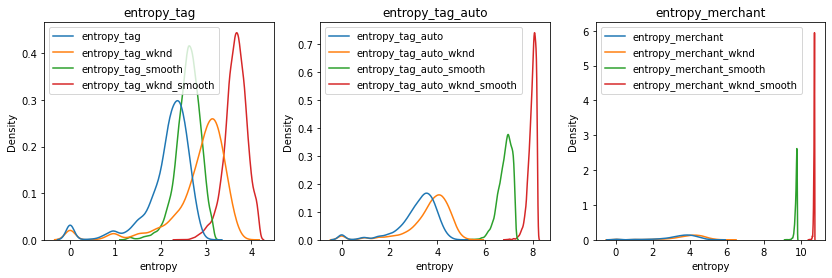

In [9]:
fig, ax = plt.subplots(1, 3, figsize=(14, 4))

for fig_idx, col_idx in enumerate(list(range(0, 12, 4))):
    sns.kdeplot(data=dfe.iloc[:, col_idx : col_idx + 4], label="cat", ax=ax[fig_idx])
    ax[fig_idx].set(title=dfe.columns[col_idx], xlabel="entropy")

The reason is that the more categories there are overall, the more categories will have a count of zero in a given user-month, and a large number of zeroes has the opposite effect on entropy scores based on smoothed and unsmoothed counts: it lowers entropy in the unsmoothed case and biases it towards the upper bound in the smoothed case. This is the case because internally, `entropy()` uses [`scipy.special.entr()`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.special.entr.html#scipy.special.entr) to calculate entropy stores as `e = sum(entr(p) for p in probs)`, where `entr(p) = 0 if p = 0` and `entr(p) = -p * log(p) for p > 0`. In the unsmoothed case, zero counts will add nothing to the entropy score. In the smoothed case, however, they are all transformed to `1/num_categories`, which means that the more zeroes there are, the more the probability distribution resembles the uniform distribution, which is the maximum entropy distribution.

**Example 1: All purchases in one category - smoothing turns zero entropy score into close to max entropy score**

In [9]:
counts = np.array([0] * 9 + [1])
probs = counts / counts.sum()
smooth_probs = (counts + 1) / (counts.sum() + len(counts))
stats.entropy(probs), stats.entropy(smooth_probs)

(0.0, 2.2718685126965625)

**Example 2: Uniform spend - smoothing has no effect on score**

In [6]:
counts = np.array([1] * 10)
probs = counts / counts.sum()
smooth_probs = (counts + 1) / (counts.sum() + len(counts))
stats.entropy(probs), stats.entropy(smooth_probs)

(2.3025850929940455, 2.3025850929940455)

Hence, for any given entropy measure, the bias resulting from smoothing increases in the number of user-months for which the probability distribution resembles a uniform distribution, and using additive smoothing for a large number of categories creates many such cases.

**muggleton2020evidence example - slight change can reverse order**

Original example

In [29]:
low_entropy = np.array([40, 0, 2, 0, 3, 0, 2, 0, 0, 0])
mid_entropy = np.array([34, 8, 4, 0, 0, 0, 0, 1, 0, 0])
hight_entropy = np.array([27, 13, 1, 4, 0, 2, 0, 0, 0, 0])

for counts in [low_entropy, mid_entropy, hight_entropy]:
    probs = counts / counts.sum()
    smooth_probs = (counts + 1) / (counts.sum() + len(counts))
    print(
        f"{stats.entropy(probs, base=2):.2f}",
        f"{stats.entropy(smooth_probs, base=2):.2f}",
    )

0.84 1.67
1.19 1.94
1.59 2.21


Reducing count on cat 1 for low entropy individual reverses order of low and mid when smoothed, but not if unsmoothed.

In [37]:
low_entropy = np.array([27, 0, 2, 0, 3, 0, 2, 0, 0, 0])

for counts in [low_entropy, mid_entropy, hight_entropy]:
    probs = counts / counts.sum()
    smooth_probs = (counts + 1) / (counts.sum() + len(counts))
    print(
        f"{stats.entropy(probs, base=2):.2f}",
        f"{stats.entropy(smooth_probs, base=2):.2f}",
    )

1.05 2.00
1.19 1.94
1.59 2.21


#### Correlation

The correlation between smoothed and unsmoothed scores is very low, and for some measures even negative, which means the choice may impact our results.

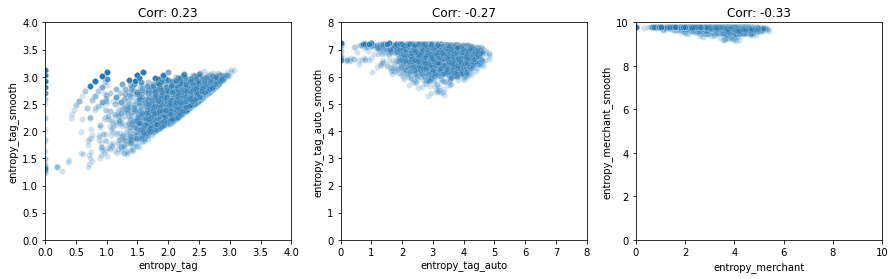

In [233]:
fig, ax = plt.subplots(1, 3, figsize=(15, 4))
for fig_idx, col_idx in enumerate(list(range(0, 12, 4))):
    x = dfe.iloc[:, col_idx]
    y = dfe.iloc[:, col_idx + 2]
    axrange = np.ceil(max(x.max(), y.max()))
    sns.scatterplot(
        x=x,
        y=y,
        alpha=0.2,
        ax=ax[fig_idx],
    ).set(xlim=(0, axrange), ylim=(0, axrange), title=f"Corr: {x.corr(y):.2}")

Why can identical unsmoothed scores result in different smoothed ones (i.e. what explains vertical variation)?

- In example 1 above, the precise score that results from smoothing depends on the count that is originally positive. The higher that count, the less uniform the distribution remains even after smoothing, and the lower the resulting entropy score.

How can correlation be negative?

- Consider example 1 and 2 above, and label resulting entropy scores H1 and H2, repsectively. Then, before smoothing, H1 < H2; after smoothing, H1 > H2. In general, smoothing alters the score of original low-entropy invididuals more than that of high-entropy individuals, which can affect the relative ordering.

#### Decision - to smooth or not to smooth?

Arguments in favour of smoothing:

- For unsmoothed data, the entropy score for an individual for whom we observe 1000 txns all spent on a single category and that of an individual with 1 txn (necessarily spent on a single category) is the same - 0. If we smooth, entropy of the first individual will be much lower (see discussion above). Hence, smoothing effectively treats the former case as more evidence for low-entropy behaviour than the latter, which is desireable.

Arguments against smoothing:

- We can handle zero counts very sensibly (the way `scipy.stats.entropy()` handles them), so we don't require smoothing for this.

- Smoothing biases entropy scores upwards (considerably so for large categories) and in a non-monotonic way, which means it could affect our results.

- For scores based on a large number of categories, the distribution of scores approaches a degenerate distribution near the max-entropy score, which is highly undesireable. So we can't use smoothing in such casese in any case, and it's highly desireable to calculate entropy in a consistent manner throughout.

- Given that for most user-months, we'll have enough observations for the results to be reliable (as opposed to the 1 txn example above), the desireable feature of differentiating between high and low obs cases is less relevant.

Hence:

- I don't think we should smooth.

### Imperfect labelling issues

In [54]:
dfr = hd.read_raw_data("777")
dfr["Auto Purpose Tag Name"].value_counts(normalize=True).head(3)

Time for read_raw_data                 : 3.64 seconds


No Tag                        0.218873
Food, Groceries, Household    0.131880
Transfers                     0.110596
Name: Auto Purpose Tag Name, dtype: float64

About 20 percent of transactions don't have a tag.

#### Issue 1: Entropy scores are biased towards zero for high-entropy individuals

**Issue**

- Fact 1: more common/standard txns such as groceries are more likely to be tagged. 

- Fact 2: untagged txns bias counts towards zero, and (unsmoothed) zero counts bias entropy towards zero.

- Hence: because by definition high-entropy individuals will have relatively more txns in less common categories, they likely have a higher number of uncategoriesed txns, which biases their entropy score towards zero.

**Solution**

- Mention as limitation

#### Issue 2: Computing entropy for all-zero-count user-months

**Issue**

There can (and almost surely will be) user-months where no spend txns has a label, which means all category counts are zero. In this case, entropy is undefined, which makes sense.

In [235]:
scipy.stats.entropy([0] * 5)

nan

**Solution**

- Retain only users which, for each month we observe them, have at least 10 labelled txns (for category we use for main analysis)

### Grocery based calculation 

Focusing on groceries is appealing because (almost everyone) needs to shop for groceries in each time period. It's thus an appeaning measure to use to look into how purchases are made rather than whether they are being made.

We calculate it based on (merchant, wknd) categories, with merchants constrained to all grocery merchants.

In [38]:
df[df.tag_auto.str.contains("groceries", na=False)].tag_auto.value_counts()

food, groceries, household     86932
groceries                          1
accessories                        0
pet - toys, training, other        0
paypal account                     0
                               ...  
games and gaming                   0
garden                             0
gas                                0
general savings                    0
zoo/theme park                     0
Name: tag_auto, Length: 187, dtype: int64

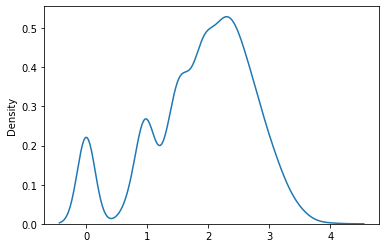

In [48]:
def grocery_shop_entropy(df):
    df = df.copy()
    is_groc_spend = df.tag_auto.eq("food, groceries, household") & df.debit
    df["merchant"] = df.merchant.where(is_groc_spend, np.nan)
    counts = _counts(df, "merchant", wknd=True)
    return _entropy(counts)


sns.kdeplot(grocery_shop_entropy(df));

### Within vs between variation

## User-level entropy